In [1]:
from datetime import datetime
from datetime import timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os
import json
import pickle
from tqdm.notebook import tqdm
import plotly.express as px
import plotly


import sklearn
from sklearn.manifold import TSNE, Isomap

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN)

from sklearn.metrics import silhouette_score

from utils.portfolio import MarkowitzPortfolio
from utils.portfolio_metrics import (calculate_measures, show_drawdown_recovery, 
                                     find_max_recovery, find_max_drawdown)

from utils.pipeline import (general_pipeline, calc_metrics, clustering_estimation, 
                            backtesting_one_model, select_assets, clustering_estimation, get_clusters)

import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('config/config.json', 'r') as file:
    config = json.load(file)
    
with open('config/config_emb_path.json', 'r') as file:
    config_emb = json.load(file)
    
rs = config['random_state']

year_start = 2021
fine_tune = True

for key in config_emb.keys():
    config_emb[key] = config_emb[key].format(year_start)

# data loading

In [3]:
df_original = pd.read_csv(config['ticker_data_close'], index_col=0)

df_na = df_original.isna().sum()
thresh = 0.05 * len(df_original)
stocks_to_drop = df_na[df_na > thresh].index.tolist()
df_original = df_original.drop(stocks_to_drop, axis=1)
df_original = df_original.dropna(axis=0)

df_original.index = pd.to_datetime(df_original.index)
df_original_train = df_original[(df_original.index < datetime(year_start, 1, 1)) ]
df_original_train.tail()

,CMCSA,LVS,EXC,GPN,MSFT,ALL,VTR,NXPI,COST,DRI,...,CERN,A,STT,EA,KO,MDLZ,HRL,AMP,MET,MCHP
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-24,50.380001,57.009998,29.835949,205.550003,222.750000,107.190002,49.189999,157.330002,364.579987,117.889999,...,707.179993,117.309998,71.779999,141.809998,53.439999,57.849998,47.169998,189.699997,46.310001,68.385002
2020-12-28,51.110001,58.980000,30.106991,208.979996,224.960007,107.470001,49.360001,158.169998,371.059998,117.739998,...,710.179993,117.830002,72.120003,140.720001,54.160000,58.270000,47.220001,189.979996,46.250000,68.125000
2020-12-29,51.549999,58.110001,29.835949,209.770004,224.149994,107.519997,49.029999,155.910004,372.720001,118.559998,...,706.280029,117.230003,71.940002,140.699997,54.130001,58.450001,46.750000,189.070007,46.009998,67.580002
2020-12-30,51.209999,58.740002,29.907274,210.139999,221.679993,108.150002,48.860001,159.389999,374.450012,117.550003,...,708.940002,117.389999,72.419998,142.050003,54.439999,58.000000,46.439999,191.350006,46.400002,68.394997
2020-12-31,52.400002,59.599998,30.114122,215.419998,222.419998,109.930000,49.040001,159.009995,376.779999,119.120003,...,721.539978,118.489998,72.779999,143.600006,54.840000,58.470001,46.610001,194.330002,46.950001,69.055000


In [4]:
df = pd.read_csv(config['ticker_data_preprocessed'], index_col=0)
print(df.shape)
df.head()

(482, 1196)


,2018-01-03,2018-01-04,2018-01-05,2018-01-08,2018-01-09,2018-01-10,2018-01-11,2018-01-12,2018-01-16,2018-01-17,...,2022-09-20,2022-09-21,2022-09-22,2022-09-23,2022-09-26,2022-09-27,2022-09-28,2022-09-29,2022-09-30,sector
A,0.025444,-0.007501,0.015988,0.002146,0.024554,-0.013655,0.000141,0.013136,-0.006971,0.011652,...,-0.019737,-0.012955,-0.016524,-0.007316,-0.009475,-0.005723,0.017351,-0.007921,-0.009695,Healthcare
AAL,-0.012266,0.006305,-0.000380,-0.009877,-0.000959,0.032642,0.049089,0.036335,-0.008380,0.003105,...,-0.016889,-0.052971,-0.039305,-0.039339,-0.028665,0.034570,0.039120,-0.039216,-0.017143,Industrials
AAP,0.009049,0.036899,0.010631,-0.007042,-0.008080,0.000905,0.021340,0.026472,-0.017595,0.012730,...,-0.013735,-0.002231,-0.008399,-0.021997,-0.017570,0.010337,0.025171,-0.022410,-0.020794,Consumer Cyclical
AAPL,-0.000174,0.004645,0.011385,-0.003714,-0.000115,-0.000229,0.005680,0.010326,-0.005082,0.016516,...,0.015665,-0.020268,-0.006375,-0.015124,0.002260,0.006566,-0.012652,-0.049119,-0.030039,Technology
ABBV,0.015649,-0.005703,0.017408,-0.016022,0.007538,-0.005487,-0.004213,0.010779,0.021427,0.018246,...,-0.006239,-0.010298,0.019243,0.000350,-0.012932,0.003612,0.020322,-0.013001,-0.059627,Healthcare


In [5]:
df_pct = df.drop(['sector'], axis=1).T
df_pct.index = pd.to_datetime(df_pct.index)

tickers_list = df_pct.columns.tolist()

df_pct.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2018-01-03,0.025444,-0.012266,0.009049,-0.000174,0.015649,0.003722,0.017300,0.002211,0.004615,0.012406,...,-0.010834,-0.006693,0.019640,-0.003426,0.012193,-0.000858,0.006932,0.019863,-0.001183,0.004598
2018-01-04,-0.007501,0.006305,0.036899,0.004645,-0.005703,-0.002225,0.017516,-0.001697,0.011841,-0.001094,...,0.005415,-0.007791,0.001384,-0.000149,0.006676,0.010180,-0.001441,0.019760,0.004147,0.005964
2018-01-05,0.015988,-0.000380,0.010631,0.011385,0.017408,0.012104,0.015408,0.002890,0.008249,0.004053,...,0.006671,-0.007003,-0.000806,0.014051,-0.001874,0.005828,0.009941,0.015576,0.000393,0.011444
2018-01-08,0.002146,-0.009877,-0.007042,-0.003714,-0.016022,0.016576,0.027086,-0.002882,0.007991,0.001745,...,-0.013314,0.007480,0.004496,0.006781,0.003611,0.001690,0.001905,0.009951,-0.004914,0.011996
2018-01-09,0.024554,-0.000959,-0.008080,-0.000115,0.007538,0.006398,0.009432,0.001700,0.003335,-0.002069,...,0.006778,-0.011667,-0.004246,-0.041728,0.000288,-0.002651,-0.016083,0.030643,0.023509,0.011719


In [6]:
df_pct_train = df_pct[(df_pct.index < datetime(year_start, 1, 1)) ]

<AxesSubplot:xlabel='Date'>

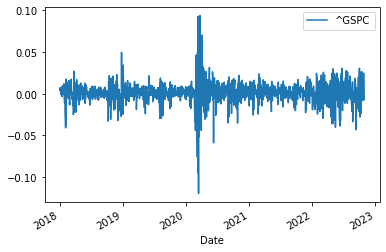

In [7]:
df_market = pd.read_csv(config['ticker_data_sp500'], index_col=0)
df_market.index = pd.to_datetime(df_market.index)
df_market = df_market.pct_change()
df_market.plot()

In [8]:
df_sectors = pd.read_csv(config['tickers_sectors_path'], index_col=0)
df_sectors = df_sectors.sort_values('ticker')
df_sectors.head()

,ticker,sector
287,A,Healthcare
462,AAL,Industrials
401,AAP,Consumer Cyclical
99,AAPL,Technology
267,ABBV,Healthcare


In [9]:
tickers = df.index.tolist()

In [10]:
# feats_tsne = TSNE(n_components=2).fit_transform(df.drop(['sector'], axis=1))
# df_tsne = pd.DataFrame({'axis0':feats_tsne[:, 0],'axis1':feats_tsne[:, 1],'sector':df['sector']})

# fig = px.scatter(df_tsne, x = 'axis0', y = 'axis1', color="sector", width=800, height=600)
# fig.show()

# Experiments

In [11]:
def custom_score_clustering_gridsearch(estimator, X, y=None):
    estimator.fit(X)
    labels_predicted = estimator.labels_
    score = silhouette_score(X, labels_predicted)
    return score

def selection_sharp(list_tickers, n_save, df_pct, riskfree_rate):
    df_pct = df_pct[list_tickers]
    
    sharp = (df_pct.mean() - riskfree_rate)/df_pct.std()
    selected_tickers = sharp.sort_values(ascending=False).head(n_save).index.tolist()
    
    return selected_tickers

# embeddings

In [12]:
emb_dict = dict()

# for name, path in config_emb.items():
#     emb_dict[name] = pd.read_csv(path, index_col=0).values

top_path = f"data/embeddings_{year_start}"
all_files = os.listdir(top_path)

for emb_path in all_files:
    
    emb_name = emb_path.replace('.csv', '')
    emb_path = top_path + '/' + emb_path
    
    emb_dict[emb_name] = pd.read_csv(emb_path, index_col=0).values

In [13]:
for method_name, data in emb_dict.items():
    print(method_name, np.sum(np.isnan(data)), data.shape)

ts2vec 0 (482, 100)
takens_one_BC_2 0 (482, 100)
takens_one_PL_2 0 (482, 100)
transformer_embds_sum_23 0 (482, 100)
transformer_embds3 0 (482, 100)
transformer_embds2 0 (482, 100)
takens_mult_PI_0_sigma=0.0005 0 (482, 100)
takens_mult_PL_2 0 (482, 100)
takens_one_BC_1 0 (482, 100)
table_finance_features 0 (482, 14)
takens_mult_PI_1_sigma=0.0005 0 (482, 100)
signal2vec_embds 0 (482, 99)
autoencoder_mlp 0 (482, 100)
takens_mult_PL_1 0 (482, 100)
tsfresh 0 (482, 100)
takens_one_BC_0 0 (482, 100)
pca 0 (482, 100)
takens_one_PI_0_sigma=0.0005 0 (482, 100)
autoencoder_conv 0 (482, 100)
takens_mult_BC_0 0 (482, 100)
takens_one_PI_2_sigma=0.0005 0 (482, 100)
takens_one_PI_1_sigma=0.0005 0 (482, 100)
takens_mult_PI_2_sigma=0.0005 0 (482, 100)
umap 0 (482, 100)
fastica 0 (482, 100)
transformer_embds1 0 (482, 100)
takens_mult_BC_2 0 (482, 100)
takens_one_PL_1 0 (482, 100)
autoencoder_lstm 0 (482, 100)
transformer_embds_sum_all 0 (482, 100)
tnse 0 (482, 3)
takens_mult_BC_1 0 (482, 100)


# pipeline

In [14]:
clust_models_init = {'KMeans': KMeans(n_clusters=config['n_clusters'], random_state=rs),
                     'Agg': AgglomerativeClustering(n_clusters=config['n_clusters']),
                     #'DBSCAN': DBSCAN(),
                    }

clust_models_params = {'KMeans': {
                   'n_clusters':np.arange(9, 14),
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
                },
                     'Agg': {
                   'n_clusters':np.arange(9, 14),
                   'linkage': ['ward', 'complete', 'average', 'single'],
                },
                     'DBSCAN':{
                   'n_clusters':np.arange(9, 14),
                   'init': ['k-means++', 'random'],
                   'algorithm':['auto', 'full', 'elkan']
                }
                }

In [15]:
riskfree = config['riskless_rate']
riskfree_rate=(1 + riskfree) **(1/252) - 1,
ret_det=(1 + 0.03) **(1/252) - 1,
    
    
clust_params = {#'clust_model':clust_models_init[clust_model_name],
                'make_grid':fine_tune, 
                #'grid_params':clust_models_params[clust_model_name],
                'grid_metric':custom_score_clustering_gridsearch}


selection_params = {'selection_method':selection_sharp,
                    'n_save':2, 
                    'riskfree_rate':riskfree_rate,}

backtesting_params = {'port_model':MarkowitzPortfolio,
                      'window_train':24, # size of train window in months
                      'window_test':1,  # size of train window in months
                       
                      'test_start_year':year_start, #start data year
                      'test_start_month':1, #start data month 
                      'test_finish_year':2022, #end data year
                      'test_finish_month':11, #end data month
                      'ret_det':ret_det
                     }

In [16]:
dict_port_methods = dict() #Считаем портфель Марковица для всех методов кластеризации
dict_weight_methods = dict()
cluster_metrics_df = pd.DataFrame() 
financial_metrics_df = pd.DataFrame() 


for emb_model_name, embedding_data in tqdm(emb_dict.items()):
    ports_df = pd.DataFrame()
    dict_weights = dict()
    
    
    for clust_model_name, clust_model in clust_models_init.items():
        
        clust_params['clust_model'] = clust_model
        clust_params['grid_params'] = clust_models_params[clust_model_name]
    
        weights_all, return_portfolio, cluster_metrics, fin_metrics = general_pipeline(
            df_pct,
            df_market,
            df_sectors, 
            embedding_data=embedding_data,
            clust_params=clust_params,
            selection_params=selection_params,
            backtesting_params=backtesting_params)
        
        cluster_metrics['clust_model'] = clust_model_name
        fin_metrics['clust_model'] = clust_model_name
        
        cluster_metrics['emb_model'] = emb_model_name
        fin_metrics['emb_model'] = emb_model_name
        
        cluster_metrics_df = pd.concat([cluster_metrics_df, pd.DataFrame(cluster_metrics).T], axis=0)
        financial_metrics_df = pd.concat([financial_metrics_df, pd.DataFrame(fin_metrics).T], axis=0)  
        
        ports_df[clust_model_name] = return_portfolio
        dict_weights[clust_model_name] = weights_all
        
    dict_port_methods[emb_model_name] = ports_df
    dict_weight_methods[emb_model_name] = dict_weights

  0%|          | 0/32 [00:00<?, ?it/s]

In [17]:
financial_metrics_df.to_csv(config['financial_metric_path'].format(year_start, fine_tune))
cluster_metrics_df.to_csv(config['clust_metric_path'].format(year_start, fine_tune))

with open(config['port_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_port_methods, f)
    
with open(config['weights_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_weight_methods, f)

### Baseline clustering

In [18]:
from tslearn.clustering import TimeSeriesKMeans, KShape
from utils.MSTcorr import MSTcorrClustering

In [19]:
tslearn_models = {'MSTcorr': MSTcorrClustering(n_clusters=config['n_clusters']),
                  'KShape' : KShape(n_clusters=config['n_clusters'], n_init=1, random_state=rs),
                  'TimeSeriesKMeans' : TimeSeriesKMeans(n_clusters=config['n_clusters'], metric="dtw", 
                                                        random_state=rs, n_jobs=4),
                  
                 }


tslearn_params = {
    'TimeSeriesKMeans' : {
                   'n_clusters':np.arange(9, 14),
                   'init': ['k-means++', 'random'],
                },
    
     'MSTcorr': {  
         'n_clusters':np.arange(9, 14),
         'linkage': ['complete', 'average', 'single'],
                },

    'KShape' : {'n_clusters':np.arange(9, 14),
                'tol': [1e-4, 1e-5, 1e-6],
                }
    
}

In [20]:
clust_params = {'make_grid':fine_tune, 
                'grid_metric':custom_score_clustering_gridsearch}

for clust_model_name, clust_model in tqdm(tslearn_models.items()):
    
    emb_model_name = clust_model_name
    clust_params['clust_model'] = clust_model
    clust_params['grid_params'] = tslearn_params[clust_model_name]
    
    ports_df = pd.DataFrame()
    dict_weights = dict()
    
    weights_all, return_portfolio, cluster_metrics, fin_metrics = general_pipeline(
        df_pct,
        df_market,
        df_sectors, 
        embedding_data=df_original_train.T.values,
        clust_params=clust_params,
        selection_params=selection_params,
        backtesting_params=backtesting_params)
    
    
    cluster_metrics['clust_model'] = clust_model_name
    fin_metrics['clust_model'] = clust_model_name

    cluster_metrics['emb_model'] = emb_model_name
    fin_metrics['emb_model'] = emb_model_name

    cluster_metrics_df = pd.concat([cluster_metrics_df, pd.DataFrame(cluster_metrics).T], axis=0)
    financial_metrics_df = pd.concat([financial_metrics_df, pd.DataFrame(fin_metrics).T], axis=0)  

    ports_df[clust_model_name] = return_portfolio
    dict_weight_methods[clust_model_name] = weights_all

dict_port_methods[emb_model_name] = ports_df
dict_weight_methods[emb_model_name] = dict_weights

  0%|          | 0/3 [00:00<?, ?it/s]

RuntimeError: can't start new thread

In [ ]:
financial_metrics_df.to_csv(config['financial_metric_path'].format(year_start, fine_tune))
cluster_metrics_df.to_csv(config['clust_metric_path'].format(year_start, fine_tune))

with open(config['port_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_port_methods, f)
    
with open(config['weights_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_weight_methods, f)

### benchmarks

In [ ]:
# index SP_500

clust_model_name = 'sp500'
emb_model_name = 'sp500'

fin_metrics= calc_metrics(df_market.loc[dict_port_methods['ts2vec'].index] .copy(), df_market, 
                                            riskfree_rate=riskfree_rate)
fin_metrics['clust_model'] = clust_model_name
fin_metrics['emb_model'] = emb_model_name

financial_metrics_df = pd.concat([financial_metrics_df, pd.DataFrame(fin_metrics).T], axis=0)  

In [ ]:
# economic sectors
clust_model_name = 'sectors'
emb_model_name = 'sectors'

clust_econ_sectors = LabelEncoder().fit_transform(df['sector'])
df_clusters = pd.DataFrame([tickers_list, clust_econ_sectors], index=['ticker', 'cluster']).T


selected_tickers = select_assets(df_clusters, df_pct, **selection_params)
df_pct_loc = df_pct[selected_tickers]
weights_all, return_portfolio = backtesting_one_model(df_pct_loc, # df with pct_changes: columns - tick, index - date
                    **backtesting_params)
cluster_metrics = clustering_estimation(df_pct.T.values, df_clusters, df_sectors)
fin_metrics = calc_metrics(return_portfolio.copy(), df_market, riskfree_rate=riskfree_rate)


cluster_metrics['clust_model'] = clust_model_name
fin_metrics['clust_model'] = clust_model_name

cluster_metrics['emb_model'] = emb_model_name
fin_metrics['emb_model'] = emb_model_name

cluster_metrics_df = pd.concat([cluster_metrics_df, pd.DataFrame(cluster_metrics).T], axis=0)
financial_metrics_df = pd.concat([financial_metrics_df, pd.DataFrame(fin_metrics).T], axis=0)  

ports_df[clust_model_name] = return_portfolio
dict_weight_methods[clust_model_name] = weights_all

dict_port_methods[emb_model_name] = ports_df
dict_weight_methods[emb_model_name] = dict_weights

# results estimation

In [ ]:
financial_metrics_df.sort_values('Sharpe', ascending=False)

In [ ]:
cluster_metrics_df.sort_values(['Sil'], ascending=False)

In [ ]:
financial_metrics_df.to_csv(config['financial_metric_path'].format(year_start, fine_tune))
cluster_metrics_df.to_csv(config['clust_metric_path'].format(year_start, fine_tune))

with open(config['port_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_port_methods, f)
    
with open(config['weights_path'].format(year_start, fine_tune), 'wb') as f:
    pickle.dump(dict_weight_methods, f)